# 构建强化学习数据集

In [31]:
unified_ref = {
    'vanco_level': (10.0, 20.0, 15.0),  # 万古霉素浓度
    'creatinine':  (0.6, 1.2, 0.9),    # 肾功能
    'wbc':         (4.0, 10.0, 7.0),   # 感染指标
    'bun':         (7.0, 20.0, 13.5)   # 尿素氮
}
unified_ref 

{'vanco_level': (10.0, 20.0, 15.0),
 'creatinine': (0.6, 1.2, 0.9),
 'wbc': (4.0, 10.0, 7.0),
 'bun': (7.0, 20.0, 13.5)}

In [32]:
import numpy as np
import pandas as pd

In [33]:
df = pd.read_excel('rawdata.xlsx')
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'rel_time', 'event_type', 'itemid',
       'totalamount_mg', 'starttime', 'vanco_start_rel', 'vanco_end_rel',
       'vanco_level(ug/mL)', 'creatinine(mg/dL)', 'wbc(K/uL)', 'bun(mg/dL)',
       'charttime', 'gender', 'anchor_age', 'patientweight', 'intime',
       'outtime', 'vitaltime', 'heart_rate', 'sbp', 'temperature', 'hr_warn',
       'sbp_warn', 'temp_warn'],
      dtype='object')

In [45]:
df

,subject_id,hadm_id,stay_id,rel_time,event_type,itemid,totalamount_mg,starttime,vanco_start_rel,vanco_end_rel,...,patientweight,intime,outtime,vitaltime,heart_rate,sbp,temperature,hr_warn,sbp_warn,temp_warn
0,10018423,29366372,30665396,5.048333,lab,NaN,NaN,NaT,NaN,NaN,...,107.0,2167-05-05 12:54:06,2167-05-06 18:40:10,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,10018423,29366372,30665396,6.348333,vitals,NaN,NaN,NaT,NaN,NaN,...,107.0,2167-05-05 12:54:06,NaN,2167-05-05 19:15:00,98.0,NaN,NaN,0.0,NaN,NaN
2,10018423,29366372,30665396,6.365000,vitals,NaN,NaN,NaT,NaN,NaN,...,107.0,2167-05-05 12:54:06,NaN,2167-05-05 19:16:00,97.0,NaN,NaN,0.0,NaN,NaN
3,10018423,29366372,30665396,6.598333,lab,NaN,NaN,NaT,NaN,NaN,...,107.0,2167-05-05 12:54:06,2167-05-06 18:40:10,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,10018423,29366372,30665396,6.598333,vitals,NaN,NaN,NaT,NaN,NaN,...,107.0,2167-05-05 12:54:06,NaN,2167-05-05 19:30:00,94.0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13340,10010867,22429197,39880770,221.466667,vitals,NaN,NaN,NaT,NaN,NaN,...,120.0,2147-12-30 09:33:00,NaN,2148-01-08 15:01:00,NaN,138.0,NaN,NaN,0.0,NaN
13341,10010867,22429197,39880770,222.450000,vitals,NaN,NaN,NaT,NaN,NaN,...,120.0,2147-12-30 09:33:00,NaN,2148-01-08 16:00:00,89.0,NaN,NaN,0.0,NaN,NaN
13342,10010867,22429197,39880770,222.483333,vitals,NaN,NaN,NaT,NaN,NaN,...,120.0,2147-12-30 09:33:00,NaN,2148-01-08 16:02:00,NaN,151.0,NaN,NaN,0.0,NaN
13343,10010867,22429197,39880770,223.450000,vitals,NaN,NaN,NaT,NaN,NaN,...,120.0,2147-12-30 09:33:00,NaN,2148-01-08 17:00:00,101.0,NaN,NaN,0.0,NaN,NaN


In [44]:
def step1_fix_creatinine(df):
    df_step = df.sort_values(['stay_id', 'rel_time']).copy()
    
    # 1. 记录原始缺失标志 (必须在填充前做)
    sparse_cols = ['creatinine(mg/dL)', 'wbc(K/uL)', 'bun(mg/dL)']
    for col in sparse_cols:
        if col in df_step.columns:
            df_step[f'{col}_is_missing'] = df_step[col].isna().astype(int)
        else:
            df_step[f'{col}_is_missing'] = 1
            df_step[col] = np.nan
    
    # 2. 正式填充肌酐 (为 PK 计算做准备)
    # 先分组前向填充，再用临床中值 0.9 填补开头
    df_step['creatinine(mg/dL)'] = df_step.groupby('stay_id')['creatinine(mg/dL)'].ffill()
    df_step['creatinine(mg/dL)'] = df_step['creatinine(mg/dL)'].fillna(0.9)
    
    # 3. 基础列补全
    df_step['patientweight'] = df_step.groupby('stay_id')['patientweight'].ffill().fillna(75.0)
    df_step['anchor_age'] = df_step.groupby('stay_id')['anchor_age'].ffill().fillna(60.0)
    
    return df_step

# 调用：
df_1 = step1_fix_creatinine(df)
df_1

,subject_id,hadm_id,stay_id,rel_time,event_type,itemid,totalamount_mg,starttime,vanco_start_rel,vanco_end_rel,...,vitaltime,heart_rate,sbp,temperature,hr_warn,sbp_warn,temp_warn,creatinine(mg/dL)_is_missing,wbc(K/uL)_is_missing,bun(mg/dL)_is_missing
0,10018423,29366372,30665396,5.048333,lab,NaN,NaN,NaT,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1
1,10018423,29366372,30665396,6.348333,vitals,NaN,NaN,NaT,NaN,NaN,...,2167-05-05 19:15:00,98.0,NaN,NaN,0.0,NaN,NaN,1,1,1
2,10018423,29366372,30665396,6.365000,vitals,NaN,NaN,NaT,NaN,NaN,...,2167-05-05 19:16:00,97.0,NaN,NaN,0.0,NaN,NaN,1,1,1
3,10018423,29366372,30665396,6.598333,lab,NaN,NaN,NaT,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4,10018423,29366372,30665396,6.598333,vitals,NaN,NaN,NaT,NaN,NaN,...,2167-05-05 19:30:00,94.0,NaN,NaN,0.0,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13340,10010867,22429197,39880770,221.466667,vitals,NaN,NaN,NaT,NaN,NaN,...,2148-01-08 15:01:00,NaN,138.0,NaN,NaN,0.0,NaN,1,1,1
13341,10010867,22429197,39880770,222.450000,vitals,NaN,NaN,NaT,NaN,NaN,...,2148-01-08 16:00:00,89.0,NaN,NaN,0.0,NaN,NaN,1,1,1
13342,10010867,22429197,39880770,222.483333,vitals,NaN,NaN,NaT,NaN,NaN,...,2148-01-08 16:02:00,NaN,151.0,NaN,NaN,0.0,NaN,1,1,1
13343,10010867,22429197,39880770,223.450000,vitals,NaN,NaN,NaT,NaN,NaN,...,2148-01-08 17:00:00,101.0,NaN,NaN,0.0,NaN,NaN,1,1,1


In [48]:
df_1[['stay_id','rel_time','event_type','creatinine(mg/dL)']].count()

stay_id              13345
rel_time             13345
event_type           13345
creatinine(mg/dL)    13345
dtype: int64

In [49]:
def step2_pk_dynamics(df):
    df_step = df.copy()
    
    # 1. 直接使用已经填好的肌酐计算 PK 参数
    gender_map = {'M': 1.0, 'F': 0.85}
    df_step['g_factor'] = df_step['gender'].map(gender_map).fillna(0.85)
    
    # CrCl (肾功能清除率)
    df_step['crcl'] = ((140 - df_step['anchor_age']) * df_step['patientweight']) / (72 * df_step['creatinine(mg/dL)']) * df_step['g_factor']
    df_step['ke'] = 0.00083 * df_step['crcl'] + 0.0044
    df_step['vd'] = df_step['patientweight'] * 0.7

    # 2. 递归计算浓度
    v_col = 'vanco_level(ug/mL)'
    if v_col not in df_step.columns: df_step[v_col] = np.nan
    
    # 转换为 values 数组进行高速递归计算
    vals = df_step[[v_col, 'totalamount_mg', 'rel_time', 'ke', 'vd', 'stay_id']].values
    for i in range(1, len(vals)):
        if vals[i, 5] == vals[i-1, 5]: # 同一病人
            dt = vals[i, 2] - vals[i-1, 2]
            # 计算上时刻到本时刻的衰减
            prev_v = vals[i-1, 0] if pd.notna(vals[i-1, 0]) else 0.0
            current_v = prev_v * np.exp(-vals[i-1, 3] * dt)
            # 加上本时刻给药导致的浓度跳升
            if pd.notna(vals[i, 1]) and vals[i, 1] > 0:
                current_v += (vals[i, 1] / vals[i, 4])
            # 如果原始数据里没有化验值，则填入 PK 计算值
            if pd.isna(df_step.iloc[i][df_step.columns.get_loc(v_col)]):
                vals[i, 0] = current_v
    
    df_step[v_col] = vals[:, 0]
    return df_step

# 调用：
df_2 = step2_pk_dynamics(df_1)
df_2

,subject_id,hadm_id,stay_id,rel_time,event_type,itemid,totalamount_mg,starttime,vanco_start_rel,vanco_end_rel,...,hr_warn,sbp_warn,temp_warn,creatinine(mg/dL)_is_missing,wbc(K/uL)_is_missing,bun(mg/dL)_is_missing,g_factor,crcl,ke,vd
0,10018423,29366372,30665396,5.048333,lab,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,1,0,1,1.00,170.077160,0.145564,74.9
1,10018423,29366372,30665396,6.348333,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,NaN,NaN,1,1,1,1.00,170.077160,0.145564,74.9
2,10018423,29366372,30665396,6.365000,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,NaN,NaN,1,1,1,1.00,170.077160,0.145564,74.9
3,10018423,29366372,30665396,6.598333,lab,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,0,0,0,1.00,153.069444,0.131448,74.9
4,10018423,29366372,30665396,6.598333,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,NaN,NaN,1,1,1,1.00,153.069444,0.131448,74.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13340,10010867,22429197,39880770,221.466667,vitals,NaN,NaN,NaT,NaN,NaN,...,NaN,0.0,NaN,1,1,1,0.85,317.333333,0.267787,84.0
13341,10010867,22429197,39880770,222.450000,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,NaN,NaN,1,1,1,0.85,317.333333,0.267787,84.0
13342,10010867,22429197,39880770,222.483333,vitals,NaN,NaN,NaT,NaN,NaN,...,NaN,0.0,NaN,1,1,1,0.85,317.333333,0.267787,84.0
13343,10010867,22429197,39880770,223.450000,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,NaN,NaN,1,1,1,0.85,317.333333,0.267787,84.0


In [59]:
df_2[df_2['stay_id'] == 30665396][['stay_id','rel_time','event_type','vanco_level(ug/mL)','creatinine(mg/dL)']]

,stay_id,rel_time,event_type,vanco_level(ug/mL),creatinine(mg/dL)
0,30665396,5.048333,lab,NaN,0.9
1,30665396,6.348333,vitals,0.000000,0.9
2,30665396,6.365000,vitals,0.000000,0.9
3,30665396,6.598333,lab,0.000000,1.0
4,30665396,6.598333,vitals,0.000000,1.0
5,30665396,6.848333,vitals,0.000000,1.0
6,30665396,7.098333,vitals,0.000000,1.0
7,30665396,7.348333,vitals,0.000000,1.0
8,30665396,7.581667,vitals,0.000000,1.0
9,30665396,8.098333,vitals,0.000000,1.0


In [60]:
def step3_fill_others(df):
    df_step = df.copy()
    
    # 1. 整合报警列 (temp_warn, sbp_warn, hr_warn)
    warn_cols = ['temp_warn', 'sbp_warn', 'hr_warn']
    for col in warn_cols: df_step[col] = df_step[col].fillna(0)
    df_step['warning'] = df_step[warn_cols].max(axis=1)
    
    # 2. 填充 WBC、BUN 和生命体征
    other_physio = ['wbc(K/uL)', 'bun(mg/dL)', 'temperature', 'sbp', 'heart_rate']
    df_step[other_physio] = df_step.groupby('stay_id')[other_physio].ffill()
    
    # 3. 兜底填充
    baselines = {'temperature': 37.0, 'sbp': 120.0, 'heart_rate': 80.0, 'wbc(K/uL)': 7.0, 'bun(mg/dL)': 15.0}
    for col, val in baselines.items():
        df_step[col] = df_step[col].fillna(val)
        
    return df_step

# 调用：
df_3 = step3_fill_others(df_2)
df_3

,subject_id,hadm_id,stay_id,rel_time,event_type,itemid,totalamount_mg,starttime,vanco_start_rel,vanco_end_rel,...,sbp_warn,temp_warn,creatinine(mg/dL)_is_missing,wbc(K/uL)_is_missing,bun(mg/dL)_is_missing,g_factor,crcl,ke,vd,warning
0,10018423,29366372,30665396,5.048333,lab,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,1,0,1,1.00,170.077160,0.145564,74.9,0.0
1,10018423,29366372,30665396,6.348333,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,1,1,1,1.00,170.077160,0.145564,74.9,0.0
2,10018423,29366372,30665396,6.365000,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,1,1,1,1.00,170.077160,0.145564,74.9,0.0
3,10018423,29366372,30665396,6.598333,lab,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,0,0,0,1.00,153.069444,0.131448,74.9,0.0
4,10018423,29366372,30665396,6.598333,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,1,1,1,1.00,153.069444,0.131448,74.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13340,10010867,22429197,39880770,221.466667,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,1,1,1,0.85,317.333333,0.267787,84.0,0.0
13341,10010867,22429197,39880770,222.450000,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,1,1,1,0.85,317.333333,0.267787,84.0,0.0
13342,10010867,22429197,39880770,222.483333,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,1,1,1,0.85,317.333333,0.267787,84.0,0.0
13343,10010867,22429197,39880770,223.450000,vitals,NaN,NaN,NaT,NaN,NaN,...,0.0,0.0,1,1,1,0.85,317.333333,0.267787,84.0,0.0


In [63]:
df_3[['stay_id','rel_time','event_type','vanco_level(ug/mL)','creatinine(mg/dL)','wbc(K/uL)', 'bun(mg/dL)', 'temperature', 'sbp', 'heart_rate']].count()

stay_id               13345
rel_time              13345
event_type            13345
vanco_level(ug/mL)    13287
creatinine(mg/dL)     13345
wbc(K/uL)             13345
bun(mg/dL)            13345
temperature           13345
sbp                   13345
heart_rate            13345
dtype: int64

In [64]:
def step4_resample(df):
    df_step = df.copy()
    df_step['step_4hr'] = np.floor(df_step['rel_time'] / 4).astype(int)
    
    rules = {
        'totalamount_mg': 'sum',
        'vanco_level(ug/mL)': 'last',
        'creatinine(mg/dL)': 'last',
        'temperature': 'mean', 'sbp': 'mean', 'heart_rate': 'mean',
        'wbc(K/uL)': 'last', 'bun(mg/dL)': 'last', 'warning': 'max',
        'creatinine(mg/dL)_is_missing': 'min', 'wbc(K/uL)_is_missing': 'min', 'bun(mg/dL)_is_missing': 'min'
    }
    
    df_grid = df_step.groupby(['stay_id', 'step_4hr']).agg(rules).reset_index()
    
    # 网格间填充 (处理空白的4小时窗)
    fill_targets = [c for c in df_grid.columns if c not in ['stay_id', 'step_4hr', 'totalamount_mg']]
    df_grid[fill_targets] = df_grid.groupby('stay_id')[fill_targets].ffill()
    df_grid['totalamount_mg'] = df_grid['totalamount_mg'].fillna(0)
    
    return df_grid

# 调用：
df_4 = step4_resample(df_3)
df_4

,stay_id,step_4hr,totalamount_mg,vanco_level(ug/mL),creatinine(mg/dL),temperature,sbp,heart_rate,wbc(K/uL),bun(mg/dL),warning,creatinine(mg/dL)_is_missing,wbc(K/uL)_is_missing,bun(mg/dL)_is_missing
0,30665396,1,0.0,0.000000,1.0,36.955556,120.000000,90.555556,16.2,14.0,0.0,0,0,0
1,30665396,2,1500.0,16.016277,1.0,36.600000,120.000000,91.000000,16.2,14.0,0.0,1,1,1
2,30665396,3,0.0,9.467027,1.0,36.600000,120.000000,98.800000,8.8,12.0,0.0,0,0,0
3,30665396,4,1500.0,25.102915,1.0,36.600000,120.000000,95.000000,8.8,12.0,0.0,1,1,1
4,30665396,5,0.0,14.838029,1.0,36.600000,120.000000,79.500000,8.8,12.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,39880770,51,1500.0,21.800862,0.6,37.000000,129.333333,94.444444,10.0,11.0,0.0,1,1,1
2109,39880770,52,0.0,8.108939,0.5,37.000000,123.111111,91.333333,10.4,9.0,0.0,0,0,0
2110,39880770,53,1500.0,20.397889,0.5,37.000000,120.666667,89.888889,10.4,9.0,0.0,1,1,1
2111,39880770,54,0.0,6.988631,0.5,37.000000,124.875000,94.750000,10.4,9.0,0.0,1,1,1


In [71]:
def step5_reward(df):
    df_step = df.copy()
    
    # 1. 预计算差值（趋势反馈）
    # creatinine 增加预示肾损伤风险，WBC 降低预示感染得到控制
    df_step['cre_diff'] = df_step.groupby('stay_id')['creatinine(mg/dL)'].diff()
    df_step['wbc_diff'] = df_step.groupby('stay_id')['wbc(K/uL)'].diff()
    
    def r_logic(row):
        r = 0.0
        
        # --- A. 血药浓度奖励 (目标: 15-20) ---
        v = row['vanco_level(ug/mL)']
        if 15.0 <= v <= 20.0: 
            r += 2.0
        elif 10.0 <= v < 15.0: 
            r += 0.5
        elif v > 25.0: 
            r -= 2.0  # 显著超标，重罚

        # --- B. 肾功能安全 (Creatinine & BUN) ---
        # 肌酐绝对值与趋势 (参考: 0.6-1.2)
        if row['creatinine(mg/dL)'] > 1.2: 
            r -= 1.0
        if row['cre_diff'] >= 0.3: 
            r -= 3.0  # AKI (急性肾损伤) 风险重罚
            
        # BUN 风险 (参考: 7.0-20.0)
        if row['bun(mg/dL)'] > 20.0:
            r -= 0.5  # 辅助肾毒性判定

        # --- C. 感染控制疗效 (WBC) (参考: 4.0-10.0) ---
        wbc = row['wbc(K/uL)']
        if wbc > 10.0:  # 处于感染状态
            if row['wbc_diff'] < 0:
                r += 0.5  # 奖励：给药后感染指标正在好转
            else:
                r -= 0.2  # 惩罚：感染持续或恶化，暗示剂量可能不足
        elif 4.0 <= wbc <= 10.0:
            r += 0.2  # 奖励：维持在正常生理区间
        else:
            r -= 0.5  # 惩罚：WBC 过低（临床极少由万古引起，但属异常状态）

        # --- D. 报警与生命体征风险 ---
        if row['warning'] == 1: 
            r -= 1.0
            
        return r

    # 应用逻辑计算
    df_step['step_reward'] = df_step.apply(r_logic, axis=1)
    
    # 处理第一行 diff() 产生的 NaN 情况（第一行通常没有趋势分）
    df_step['step_reward'] = df_step['step_reward'].fillna(0)
    
    return df_step

# 调用
df_final = step5_reward(df_4)
df_final

,stay_id,step_4hr,totalamount_mg,vanco_level(ug/mL),creatinine(mg/dL),temperature,sbp,heart_rate,wbc(K/uL),bun(mg/dL),warning,creatinine(mg/dL)_is_missing,wbc(K/uL)_is_missing,bun(mg/dL)_is_missing,cre_diff,wbc_diff,step_reward
0,30665396,1,0.0,0.000000,1.0,36.955556,120.000000,90.555556,16.2,14.0,0.0,0,0,0,NaN,NaN,-0.2
1,30665396,2,1500.0,16.016277,1.0,36.600000,120.000000,91.000000,16.2,14.0,0.0,1,1,1,0.0,0.0,1.8
2,30665396,3,0.0,9.467027,1.0,36.600000,120.000000,98.800000,8.8,12.0,0.0,0,0,0,0.0,-7.4,0.2
3,30665396,4,1500.0,25.102915,1.0,36.600000,120.000000,95.000000,8.8,12.0,0.0,1,1,1,0.0,0.0,-1.8
4,30665396,5,0.0,14.838029,1.0,36.600000,120.000000,79.500000,8.8,12.0,0.0,1,1,1,0.0,0.0,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,39880770,51,1500.0,21.800862,0.6,37.000000,129.333333,94.444444,10.0,11.0,0.0,1,1,1,0.0,0.0,0.2
2109,39880770,52,0.0,8.108939,0.5,37.000000,123.111111,91.333333,10.4,9.0,0.0,0,0,0,-0.1,0.4,-0.2
2110,39880770,53,1500.0,20.397889,0.5,37.000000,120.666667,89.888889,10.4,9.0,0.0,1,1,1,0.0,0.0,-0.2
2111,39880770,54,0.0,6.988631,0.5,37.000000,124.875000,94.750000,10.4,9.0,0.0,1,1,1,0.0,0.0,-0.2


## 检查reward

In [73]:
def check_reward_distribution(df):
    print("--- Reward 整体分布统计 ---")
    print(df['step_reward'].describe())
    
    # 统计正负奖励的占比
    pos_r = (df['step_reward'] > 0).sum() / len(df) * 100
    neg_r = (df['step_reward'] < 0).sum() / len(df) * 100
    zero_r = (df['step_reward'] == 0).sum() / len(df) * 100
    
    print(f"\n正奖励占比: {pos_r:.2f}% (模型倾向的行为)")
    print(f"负奖励占比: {neg_r:.2f}% (模型应规避的行为)")
    print(f"零奖励占比: {zero_r:.2f}%")
    
    # 检查最极端的扣分情况
    print("\n最严重的 5 个惩罚点:")
    display(df.nsmallest(5, 'step_reward')[['stay_id', 'vanco_level(ug/mL)', 'cre_diff', 'wbc(K/uL)', 'warning', 'step_reward']])

check_reward_distribution(df_final)

--- Reward 整体分布统计 ---
count    2113.000000
mean       -0.734737
std         1.173248
min        -5.700000
25%        -1.700000
50%        -0.700000
75%         0.200000
max         2.500000
Name: step_reward, dtype: float64

正奖励占比: 30.43% (模型倾向的行为)
负奖励占比: 68.58% (模型应规避的行为)
零奖励占比: 0.99%

最严重的 5 个惩罚点:


,stay_id,vanco_level(ug/mL),cre_diff,wbc(K/uL),warning,step_reward
478,32359580,8.660680,0.6,22.5,1.0,-5.7
900,34531557,0.000000,0.5,10.5,1.0,-5.7
1294,36059427,0.000000,0.5,12.4,1.0,-5.7
1381,36753294,0.000000,0.5,36.8,1.0,-5.7
92,30932571,5.467197,0.5,2.1,0.0,-5.0


In [74]:
def verify_clinical_logic(df):
    print("\n--- 临床逻辑验证 ---")
    
    # 场景 A: 感染控制奖励 (WBC 高位下降)
    infection_control = df[(df['wbc(K/uL)'] > 10) & (df['wbc_diff'] < 0)].head(3)
    print("\n[场景A] 感染控制中 (WBC > 10 且下降):")
    display(infection_control[['stay_id', 'wbc(K/uL)', 'wbc_diff', 'step_reward']])
    
    # 场景 B: 肾毒性惩罚 (BUN 或 Cr 过高)
    renal_risk = df[(df['creatinine(mg/dL)'] > 1.2) | (df['bun(mg/dL)'] > 20)].head(3)
    print("\n[场景B] 肾功风险 (Cr > 1.2 或 BUN > 20):")
    display(renal_risk[['stay_id', 'creatinine(mg/dL)', 'bun(mg/dL)', 'cre_diff', 'step_reward']])
    
    # 场景 C: 完美达标 (浓度 15-20 且 WBC/Cr 正常)
    perfect_state = df[(df['vanco_level(ug/mL)'].between(15, 20)) & (df['creatinine(mg/dL)'] <= 1.2)].head(3)
    print("\n[场景C] 完美达标状态:")
    display(perfect_state[['stay_id', 'vanco_level(ug/mL)', 'creatinine(mg/dL)', 'step_reward']])

verify_clinical_logic(df_final)


--- 临床逻辑验证 ---

[场景A] 感染控制中 (WBC > 10 且下降):


,stay_id,wbc(K/uL),wbc_diff,step_reward
68,30849778,14.2,-6.4,1.0
73,30849778,12.6,-1.6,2.5
81,30932571,16.7,-28.9,1.0



[场景B] 肾功风险 (Cr > 1.2 或 BUN > 20):


,stay_id,creatinine(mg/dL),bun(mg/dL),cre_diff,step_reward
7,30757476,1.4,34.0,NaN,-1.7
8,30757476,1.2,31.0,-0.2,-0.7
9,30757476,1.2,31.0,0.0,-0.3



[场景C] 完美达标状态:


,stay_id,vanco_level(ug/mL),creatinine(mg/dL),step_reward
1,30665396,16.016277,1.0,1.8
67,30849778,16.443772,0.5,1.8
73,30849778,18.799510,0.5,2.5


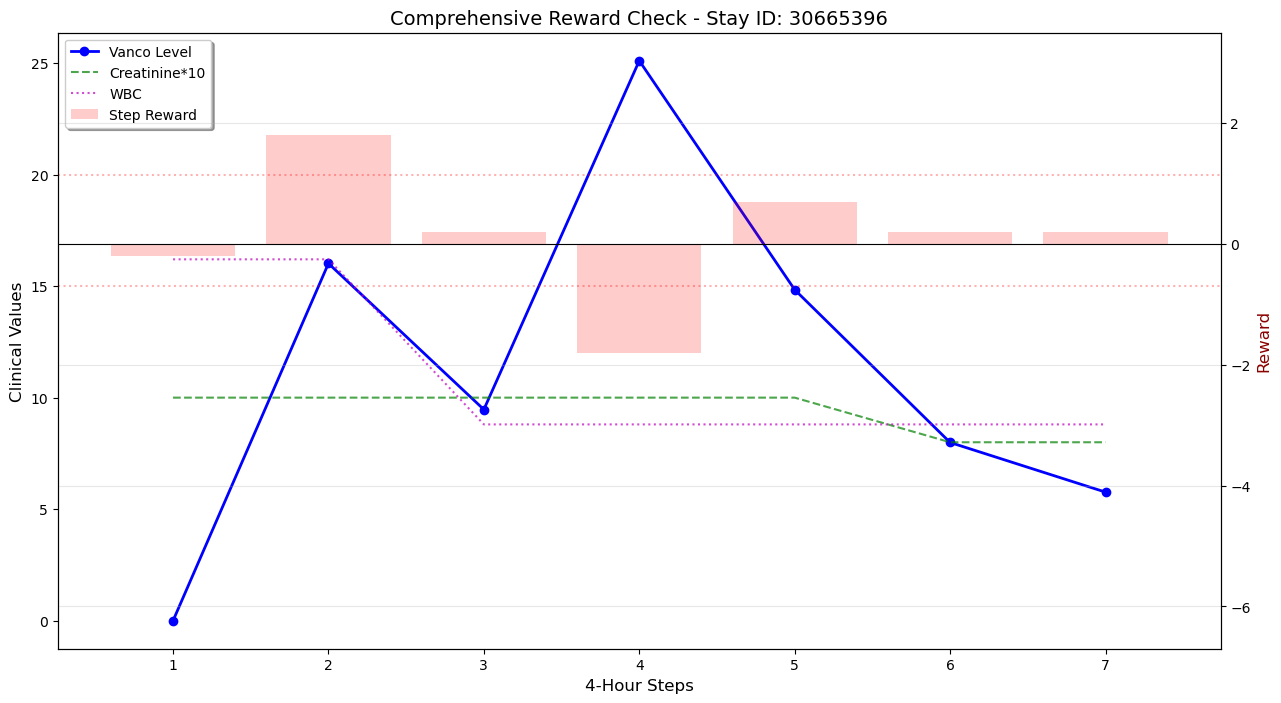

In [75]:
import matplotlib.pyplot as plt

def plot_comprehensive_check(df, target_stay_id=None):
    if target_stay_id is None:
        target_stay_id = df['stay_id'].iloc[0]
        
    p_df = df[df['stay_id'] == target_stay_id].sort_values('step_4hr')
    
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # --- 左轴: 浓度, 肌酐, WBC ---
    ax1.set_xlabel('4-Hour Steps', fontsize=12)
    ax1.set_ylabel('Clinical Values', fontsize=12)
    
    # 浓度 (主线)
    l1, = ax1.plot(p_df['step_4hr'], p_df['vanco_level(ug/mL)'], 'b-o', label='Vanco Level', linewidth=2)
    # 肌酐 * 10 (虚线)
    l2, = ax1.plot(p_df['step_4hr'], p_df['creatinine(mg/dL)']*10, 'g--', label='Creatinine*10', alpha=0.7)
    # WBC (点线)
    l3, = ax1.plot(p_df['step_4hr'], p_df['wbc(K/uL)'], 'm:', label='WBC', alpha=0.7)
    
    # 目标线
    ax1.axhline(y=15, color='r', linestyle=':', alpha=0.3, label='Target 15-20')
    ax1.axhline(y=20, color='r', linestyle=':', alpha=0.3)
    
    # --- 右轴: Reward ---
    ax2 = ax1.twinx()
    ax2.set_ylabel('Reward', color='darkred', fontsize=12)
    bars = ax2.bar(p_df['step_4hr'], p_df['step_reward'], alpha=0.2, color='red', label='Step Reward')
    ax2.axhline(y=0, color='black', linewidth=0.8)
    ax2.set_ylim(df['step_reward'].min()-1, df['step_reward'].max()+1)

    # 合并图例
    lines = [l1, l2, l3, bars]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', frameon=True, shadow=True)
    
    plt.title(f'Comprehensive Reward Check - Stay ID: {target_stay_id}', fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()

# 运行可视化
plot_comprehensive_check(df_final)

In [76]:
df_final.to_excel('ready_data.xlsx')

In [ ]:
df_final.to_csv('intermediate_data/ready_data.csv', index=False)